### imports

In [1]:
from neuralmonkey.classes.session import load_mult_session_helper
from pythonlib.tools.stroketools import strokesInterpolate2
import pythonlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import math
import os
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

### Session helper functions

In [3]:
################################################
### Extracting a Session's successful Trialcodes/Trialnums ###
################################################

# get a list of successful trialcodes
def getSuccessfulTrialCodes(sn):
    D = sn.Datasetbeh
    Dcopy = D.copy()
    Dcopy.preprocessGood(params=["one_to_one_beh_task_strokes"]) # prunes Dcopy to keep only successful trials
    
    return Dcopy.Dat['trialcode'].tolist()

# from the list of trialcodes, get matching list of NEURAL trials
def getNeuralTrialNumsFromTrialCodes(sn, trialcode_list):
    D = sn.Datasetbeh
    trials = []
    for tc in trialcode_list:
        # make sure there is exactly one matching trialcode
        #index_dataset = D.Dat[(D.Dat["trialcode"]==tc)].index
        #assert len(index_dataset)==1

        # pull out these datapoints from trial-level dataset
        t = sn.datasetbeh_trialcode_to_trial(tc)
        trials.append(t)
        #ons, offs = sn.strokes_extract_ons_offs(trialtdt)
    return trials

# get a list of successful trialnums
def getSuccessfulNeuralTrialNums(sn):
    trialcodes = getSuccessfulTrialCodes(sn)
    return getNeuralTrialNumsFromTrialCodes(sn, trialcodes)


################################################
### Extracting/Plotting Eye-Tracking Data ###
################################################

# returns smoothed and transformed x,y data for a session/trialnum
def getEyeXYSmoothedAndTransformed(sn, trialnum, PLOT=True):
    # get TRANSFORMED xy-coordinates (used calibration matrix to map to screen)
    st = sn.beh_extract_eye_good(trialnum)
    times = st[0]
    x_aff = st[1][:,0]
    y_aff = st[1][:,1]

    # SMOOTH DATA
    from pythonlib.tools.timeseriestools import smoothDat
    x_aff_sm = smoothDat(x_aff, window_len=10)
    y_aff_sm = smoothDat(y_aff, window_len=10)
    
    if PLOT==True:
        fig, axes = plt.subplots(2,1, figsize=(10, 10))
        # plot smoothed x-data
        axes[0].plot(times,x_aff_sm)
        # plot smoothed y-data
        axes[1].plot(times,y_aff_sm)
        return x_aff_sm, y_aff_sm, times, axes
    else:
        return x_aff_sm, y_aff_sm, times

# plot the (x,y) data over time for eye tracking data
def plotEyeTrackingTrace(times, x_vals, y_vals, ax, color="b"):
    ax.plot(x_vals, y_vals, "-k", alpha=0.3)
    ax.scatter(x_vals, y_vals, c=times, alpha=0.5, marker="o")   
    

# get the start, end times for the window spanned by start_event, end_event
def getTimeWindowOfEvents(sn, trial, start_event, end_event):
    # keep just times between [start_event, end_event]
    dict_event_times = sn.events_get_time_sorted(trial, list_events=(start_event, end_event))[0]
    start_time = dict_event_times[start_event]
    end_time = dict_event_times[end_event]
    
    return start_time, end_time


# return mask array of whether within bounding box
def getBoundingBoxMask(x, y, minx, miny, maxx, maxy):
    assert len(x) == len(y), "xy must be same length"
    xn = np.array(x)
    yn = np.array(y)

    result = ((xn >= minx) & (xn <= maxx) & (yn >= miny) & (yn <= maxy))
    #print(result)
    return result

## Part 1: export x,y,times,outlier_mask to MATLAB

In [4]:
## LOAD IN SESSION ##

# preprocessed datasets: Diego-230603 (ok), Pancho-221020 (ok), Diego-230626 (primsingrid), Diego-230616 (26 singleprims)
date = 230626
animal = "Diego"
session = 0

# change to base dir
os.chdir("/home/kgg/Desktop/eyetracking_analyses/")

# mkdir for animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session)
os.makedirs(dirn, exist_ok=True)
os.chdir(dirn)

# load session
MS = load_mult_session_helper(date, animal)
sn = MS.SessionsList[session]

Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230626*/**
Found this many paths:
2
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626/Diego-230626-104011
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626/Diego-230626-124757
session:  0
Beh Sessions that exist on this date:  {230626: [(1, 'primsingridall4c'), (2, 'primsingridall4c2')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['primsingridall4c']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230626*/**
Found this many paths:
2
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626/Diego-230626-104011
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626/Diego-230626-124757
{'filename_components_hyphened': ['Diego', '230626', '104011'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Diego', '/home/kgg/mnt/Freiwald/ltian/recordings/Dieg

** Loading tank data from local (previusly cached)
== Done
== Trying to load events data
Loading this events (pd) locally to:  /data4/Kedar/neural_preprocess/recordings/Diego/230626/Diego-230626-104011/events_photodiode.pkl
== Done
** MINIMAL_LOADING, therefore loading previuosly cached data
... Generated these...
self.BehTrialMapList [(1, 0)]
self.BehTrialMapListGood {0: (0, 1), 1: (0, 2), 2: (0, 3), 3: (0, 4), 4: (0, 5), 5: (0, 6), 6: (0, 7), 7: (0, 8), 8: (0, 9), 9: (0, 10), 10: (0, 11), 11: (0, 12), 12: (0, 13), 13: (0, 14), 14: (0, 15), 15: (0, 16), 16: (0, 17), 17: (0, 18), 18: (0, 19), 19: (0, 20), 20: (0, 21), 21: (0, 22), 22: (0, 23), 23: (0, 24), 24: (0, 25), 25: (0, 26), 26: (0, 27), 27: (0, 28), 28: (0, 29), 29: (0, 30), 30: (0, 31), 31: (0, 32), 32: (0, 33), 33: (0, 34), 34: (0, 35), 35: (0, 36), 36: (0, 37), 37: (0, 38), 38: (0, 39), 39: (0, 40), 40: (0, 41), 41: (0, 42), 42: (0, 43), 43: (0, 44), 44: (0, 45), 45: (0, 46), 46: (0, 47), 47: (0, 48), 48: (0, 49), 49: (0, 50

0 _behclass_alignsim_compute
200 _behclass_alignsim_compute
Running D._behclass_tokens_extract_datsegs
0 _behclass_tokens_extract_datsegs
200 _behclass_tokens_extract_datsegs
stored in self.Dat[BehClass]
Extracted successfully for session:  0
session:  1
Beh Sessions that exist on this date:  {230626: [(1, 'primsingridall4c'), (2, 'primsingridall4c2')]}
------------------------------
Loading this neural session: 1
Loading these beh expts: ['primsingridall4c2']
Loading these beh sessions: [2]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230626*/**
Found this many paths:
2
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626/Diego-230626-104011
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626/Diego-230626-124757
{'filename_components_hyphened': ['Diego', '230626', '124757'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Diego', '/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230626'], 'basedirs_fi

** Loading tank data from local (previusly cached)
== Done
== Trying to load events data
Loading this events (pd) locally to:  /data4/Kedar/neural_preprocess/recordings/Diego/230626/Diego-230626-124757/events_photodiode.pkl
== Done
** MINIMAL_LOADING, therefore loading previuosly cached data
... Generated these...
self.BehTrialMapList [(1, 0)]
self.BehTrialMapListGood {0: (0, 1), 1: (0, 2), 2: (0, 3), 3: (0, 4), 4: (0, 5), 5: (0, 6), 6: (0, 7), 7: (0, 8), 8: (0, 9), 9: (0, 10), 10: (0, 11), 11: (0, 12), 12: (0, 13), 13: (0, 14), 14: (0, 15), 15: (0, 16), 16: (0, 17), 17: (0, 18), 18: (0, 19), 19: (0, 20), 20: (0, 21), 21: (0, 22), 22: (0, 23), 23: (0, 24), 24: (0, 25), 25: (0, 26), 26: (0, 27), 27: (0, 28), 28: (0, 29), 29: (0, 30), 30: (0, 31), 31: (0, 32), 32: (0, 33), 33: (0, 34), 34: (0, 35), 35: (0, 36), 36: (0, 37), 37: (0, 38), 38: (0, 39), 39: (0, 40), 40: (0, 41), 41: (0, 42), 42: (0, 43), 43: (0, 44), 44: (0, 45), 45: (0, 46), 46: (0, 47), 47: (0, 48), 48: (0, 49), 49: (0, 50

In [11]:
success_neural_trials = getSuccessfulNeuralTrialNums(sn)
# store valid trialnums
neuraltnums = []
tcodes = []

# get bounding box
# - format: [[-x, -y], [+x, +y]]. does not save in self
#bounding_box = sn.Datasetbeh.recomputeSketchpadEdgesAll(strokes_ver="strokes_task")
#print(bounding_box)


# loop thru trials and save xy data
for ntrial in success_neural_trials:
    
    # get sampling rate
    t,v,fs_raw = sn.extract_data_tank_streams("eyex", ntrial, ploton=False)

    # get XY smoothed / transformed on eye calibration matrix
    x_raw,y_raw,times_raw = getEyeXYSmoothedAndTransformed(sn, ntrial, False)
    
    # resample x, y, times using integer sampling rate
    fs_new = 200
    stroke_raw = [np.array([x_raw, y_raw, times_raw]).T] # dummy stroke list
    stroke_intp = strokesInterpolate2(stroke_raw, ["fsnew", fs_new, fs_raw])
    stroke_resampled = stroke_intp[0]
    x_rs = stroke_resampled[:,0]
    y_rs = stroke_resampled[:,1]
    times_rs = stroke_resampled[:,2]

    # save neuraltnums, tcodes
    neuraltnums.append(ntrial)
    tcodes.append(sn.datasetbeh_trial_to_trialcode(ntrial))
    
    # save data to be loaded into MATLAB
    fname = "ntrial" + str(ntrial) + ".mat"
    scipy.io.savemat(fname, dict(x=x_rs, y=y_rs, times=times_rs, fs_hz=fs_new))


*** RUNNING D.preprocessGood using these params:
['one_to_one_beh_task_strokes']
-- Len of D, before applying this param: one_to_one_beh_task_strokes, ... 298
after: 223
-- loaded presaved data: /home/kgg/mnt/Freiwald/kgupta/macaque_data/Diego/230626/230626_103641_primsingridall4c_Diego_1.pkl


In [6]:
# save trial numbers for later use in MATLAB
scipy.io.savemat("all_ntrialnums.mat", dict(neuraltrialnums=neuraltnums))

# save trialcodes for later use in MATLAB
scipy.io.savemat("all_trialcodes.mat", dict(trialcodes=tcodes))

# Part 2: after running ClusterFix in MATLAB, load in fixation/saccade times 

In [5]:
# load in results
mat = scipy.io.loadmat('clusterfix_results.mat')

In [6]:
# add results to dataframe

mat_vars = ['neuraltrialnum', 'trialcode', 'fs', 'x', 'y', 'times', 'fixation_start_inds',
            'fixation_end_inds', 'fixation_centroids_x', 'fixation_centroids_y', 
            'saccade_start_inds', 'saccade_end_inds']
tmp = []
for i in range(len(mat['RESULTS'][0])):
    neuraltrialnum = mat['RESULTS'][0]['neuraltrialnum'][i][0,0]
    tcode = mat['RESULTS'][0]['trialcode'][i][0]
    fs = mat['RESULTS'][0]['fs'][i][0,0]
    x = mat['RESULTS'][0]['x'][i][0]
    y = mat['RESULTS'][0]['y'][i][0]
    times = mat['RESULTS'][0]['times'][i][0]
    
    # get start, end inds for fixations/saccades
    fixation_start_inds = mat['RESULTS'][0]['fixation_inds'][i][0]
    fixation_end_inds = mat['RESULTS'][0]['fixation_inds'][i][1]
    saccade_start_inds = mat['RESULTS'][0]['saccade_inds'][i][0]
    saccade_end_inds = mat['RESULTS'][0]['saccade_inds'][i][1]
    
    # get centroids x,y
    fixation_centroids_x = mat['RESULTS'][0]['fixation_centroids'][i][0]
    fixation_centroids_y = mat['RESULTS'][0]['fixation_centroids'][i][1]
    
    dat = [neuraltrialnum, tcode, fs, x, y, times, fixation_start_inds, fixation_end_inds,
            fixation_centroids_x, fixation_centroids_y, saccade_start_inds, saccade_end_inds]
    tmp.append({})
    for v, d in zip(mat_vars, dat):
        tmp[-1][v]=d
        
clusterfix_results = pd.DataFrame(tmp, columns=mat_vars)

In [7]:
clusterfix_results

,neuraltrialnum,trialcode,fs,x,y,times,fixation_start_inds,fixation_end_inds,fixation_centroids_x,fixation_centroids_y,saccade_start_inds,saccade_end_inds
0,0,230626-1-1,0.005,"[509.1961455791966, 508.9960637886196, 508.871...","[93.50838228800662, 92.94728740877918, 92.2610...","[-1.0049803164584112, -0.9999781987865703, -0....","[1, 92, 162, 209, 268, 467, 512, 611, 658, 854...","[73, 149, 195, 254, 450, 496, 597, 642, 836, 8...","[500.85255301108424, 96.3089200197879, 422.914...","[112.91118301189327, -188.0209380085269, 52.24...","[74, 150, 196, 256, 452, 497, 598, 643, 837, 8...","[91, 161, 207, 267, 466, 511, 610, 657, 853, 8..."
1,1,230626-1-2,0.005,"[205.21817956382225, 206.15928582233164, 206.3...","[-364.993010156066, -365.44805624155384, -364....","[-0.9999634006475091, -0.9949619856093105, -0....","[32, 81, 134, 211, 259, 309, 356, 427, 524, 55...","[73, 119, 192, 243, 298, 347, 408, 503, 546, 5...","[-136.12219667819755, -174.86913668282884, 138...","[-540.7604309031117, -588.4863848213953, -146....","[19, 74, 120, 193, 244, 299, 348, 409, 505, 54...","[31, 80, 133, 210, 258, 307, 354, 426, 522, 55..."
2,2,230626-1-3,0.005,"[263.25662583951464, 263.0760914225285, 262.32...","[-2.3973412774113423, 0.3262178518130401, 2.53...","[-1.0009864606340244, -0.995985078999948, -0.9...","[4, 35, 75, 215, 264, 317, 347, 457, 514, 560,...","[20, 59, 202, 250, 307, 336, 438, 493, 547, 58...","[261.5456880167543, -18.504587467491174, 478.7...","[15.533634624638498, 122.40822824701385, 150.6...","[21, 60, 203, 251, 308, 337, 439, 494, 548, 58...","[33, 74, 213, 263, 316, 346, 456, 513, 558, 59..."
3,3,230626-1-4,0.005,"[-360.52804891278794, -358.24478765141856, -35...","[-47.03163875858087, -47.20202610761198, -45.6...","[-1.0004194002664377, -0.9954174203759695, -0....","[4, 63, 147, 218, 278, 323, 381, 441, 480, 533...","[49, 125, 207, 260, 311, 372, 420, 471, 511, 5...","[-360.5692059493012, -177.728660826663, 334.45...","[-44.52282460723927, 54.65730012003782, -57.43...","[50, 127, 208, 261, 312, 373, 421, 472, 512, 5...","[62, 146, 217, 277, 322, 380, 440, 479, 532, 5..."
4,4,230626-1-5,0.005,"[376.1834888382914, 374.3329128763432, 373.368...","[19.029293632156076, 23.640907352672816, 28.69...","[-1.0011265764319859, -0.9961251869557838, -0....","[4, 52, 201, 289, 317, 444, 495, 522, 562, 621...","[34, 187, 272, 307, 430, 476, 508, 549, 612, 6...","[368.35773935266786, 81.43327406494258, 177.23...","[60.31446622139998, -80.7601529619581, 53.3670...","[36, 188, 273, 308, 431, 477, 509, 550, 613, 6...","[50, 199, 288, 316, 442, 493, 521, 561, 620, 6..."
...,...,...,...,...,...,...,...,...,...,...,...,...
218,438,230626-1-439,0.005,"[464.5177814181355, 463.97432869000016, 462.44...","[147.77919597394092, 148.28857935970328, 149.3...","[-1.0000410852262576, -0.9950398323760656, -0....","[19, 50, 101, 148, 188, 240, 272, 434, 479, 53...","[37, 81, 137, 173, 225, 259, 413, 466, 516, 56...","[347.81189468486497, 456.8141842110849, 86.706...","[155.92350490114902, 149.7479476994758, -60.11...","[38, 82, 138, 174, 226, 260, 414, 467, 517, 57...","[48, 100, 147, 187, 239, 271, 433, 478, 537, 5..."
219,439,230626-1-440,0.005,"[-68.76040249007218, -66.95619678734107, -66.8...","[38.296933343514, 37.17345046236589, 38.184498...","[-0.9995449058042141, -0.9945431983842482, -0....","[309, 418, 434, 510, 545, 599, 639, 676, 794, ...","[406, 425, 493, 532, 578, 626, 664, 784, 812, ...","[-284.4012137547758, 115.69206619943635, 17.07...","[604.9365135652005, -280.33464613238533, -293....","[299, 408, 427, 494, 533, 579, 627, 665, 785, ...","[308, 417, 433, 509, 544, 598, 638, 675, 793, ..."
220,440,230626-1-441,0.005,"[-100.5128915267537, -100.64542107707639, -98....","[-219.8990763672809, -215.15278654279774, -210...","[-0.9999541779316132, -0.9949537201969311, -0....","[295, 411, 506, 577, 621, 652, 730, 770, 829, ...","[399, 492, 551, 605, 636, 710, 758, 803, 862, ...","[-284.38968618580986, 347.91610061290305, 470....","[604.9049698453866

### save saccade, fixation onsets/offsets into .csv to be loaded by neuralmonkey/session.py

In [11]:
from numpy import savetxt

#for i in range(len(neuraltnums)):
for index, row in clusterfix_results.iterrows():
    tnum = row['neuraltrialnum']
    print("tnum", tnum)
    tcode = row['trialcode']
    print("tcode", tcode)
    
    x_t = row['x']
    y_t = row['y']
    times_t = row['times']
    
    # get the FIXATIONS belonging to this trial
    fixation_start_inds = row['fixation_start_inds']
    fixation_end_inds = row['fixation_end_inds']
    fixation_centroids_x = row['fixation_centroids_x']
    fixation_centroids_y = row['fixation_centroids_y']
    centroid_pairs = [[x,y] for x,y in zip(fixation_centroids_x, fixation_centroids_y)]
    
    # get the times of the FIXATIONS
    fixation_start_times = times_t[fixation_start_inds]
    fixation_end_times = times_t[fixation_end_inds]
    print("fixation start times", fixation_start_times)
    print("fixation end times", fixation_end_times)

    # TODO: remove any fixations that contain outlier times... (must compute bounding box)
        
    # save fixation start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-onsets.csv"
    savetxt(fname, fixation_start_times, delimiter=',')
    
    # save fixation centroids using TRIALCODE, to load into session.py
    fname = f"{tcode}-fixation-centroids.csv"
    savetxt(fname, centroid_pairs, delimiter=",")
        
    # get the times of the SACCADES
    saccade_start_inds = row['saccade_start_inds']
    saccade_end_inds = row['saccade_end_inds']
    saccade_start_times = times_t[saccade_start_inds]
    saccade_end_times = times_t[saccade_end_inds]
    
    print("saccade start times", saccade_start_times)
    print("saccade end times", saccade_end_times)
    
    # TODO: remove any saccades that contain outlier times
    
    # save saccade start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-saccade-onsets.csv"
    savetxt(fname, saccade_start_times, delimiter=',')

tnum 0
tcode 230626-1-1
fixation start times [-0.9999782  -0.54478549 -0.19463725  0.04046228  0.33558722  1.33100864
  1.55610393  2.05131358  2.28641311  3.26682818  3.45690865  3.68700606
  3.82206324  4.38230042  4.61239783  4.8024783   4.93253336  5.12261383
  5.35271124  6.18306278  6.34813266  6.82833596  7.33354984  7.6036642
  7.78374043  7.96881879  9.12430797  9.47945832  9.61951762  9.77958538]
fixation end times [-0.63982573 -0.25966478 -0.02956737  0.26555757  1.24597264  1.47607005
  1.98128393  2.20637923  3.17679006  3.39688323  3.63198277  3.74703147
  4.31227077  4.55737453  4.73244865  4.86750583  5.0575863   5.28768371
  6.14304584  6.29811148  6.76831055  7.24851384  7.52863243  7.72871714
  7.90879337  9.05928044  9.42443503  9.54948797  9.72956421  9.98967433]
saccade start times [-0.63482361 -0.25466267 -0.02456525  0.27556181  1.25597687  1.48107217
  1.98628605  2.21138135  3.18179217  3.40188535  3.641987    3.75203359
  4.31727289  4.56237665  4.73745077  4

tnum 248
tcode 230626-1-249
fixation start times [-0.97960426 -0.31951246  0.26056821  0.6006155   0.88065445  1.03067531
  1.46573582  1.65076155  1.9207991   2.60589438  2.84592776  3.05095628
  3.23098131  3.45101191  3.89607381  4.11110371  4.29112875  4.46615309
  4.7861976   5.28126645  5.58630887  5.83134295  6.13638537  6.3314125
  6.47143197  6.881489    7.10652029  7.33655228  7.70160305  8.23167677
  8.68674006  8.93677483  9.10679848  9.72688471 10.57700294 10.70702102
 11.02706553 11.1770864  11.34210935 11.53713647 11.7171615  11.89718654
 12.07721158 12.32724635 12.47726721 12.56727973 12.66229295 12.88232355
 13.22237084 13.82745499 14.17250297]
fixation end times [-0.36951942  0.20055987  0.55560924  0.78064054  0.99567044  1.39072538
  1.60075459  1.86079076  2.51588186  2.79092011  2.99094793  3.16597227
  3.39100357  3.84106616  4.05609606  4.2311204   4.40614475  4.74619204
  5.2312595   5.52630053  5.78633669  6.07637703  6.26640346  6.42142502
  6.84148343  7.051

# Part 3: extract Snippets with event "saccon" or "fixation-onset",and plot rasters etc.

In [8]:
from neuralmonkey.classes.snippets import Snippets, extraction_helper

# Turn on debug mode, this prunes sites and trials, so below runs faster
DEBUG = False
sn._DEBUG_PRUNE_SITES = DEBUG
sn._DEBUG_PRUNE_TRIALS = DEBUG

In [9]:
sn.PopAnalDict = {}

In [12]:
if DEBUG:
    # option1 - get first 5 trials, to test
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat.iloc[0:5]
else:
    # option2 - get all trialcodes from tcodes
    dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
    dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat[dataset_pruned_for_trial_analysis.Dat["trialcode"].isin(tcodes)].reset_index(drop=True)

In [13]:
# Main code for extracting Snippets (SP)

# # == MODIFY THESE:
list_events = ["fixon"] # each event defines a snippet
list_pre_dur = [-0.4]
list_post_dur = [0.4]

# == MODIFY THESE:
# list_events = ["go"] # each event defines a snippet
# list_pre_dur = [-0.5]
# list_post_dur = [0.5]

# == IGNORE THESE:
which_level = "flex"
list_features_extraction = []
list_features_get_conjunction = []
trials_prune_just_those_including_events=False
fail_if_times_outside_existing=False

SP = Snippets(sn,
    which_level,
    list_events,
    list_features_extraction,
    list_features_get_conjunction,
    list_pre_dur,
    list_post_dur,
    strokes_only_keep_single=False,
    tasks_only_keep_these=None,
    prune_feature_levels_min_n_trials=None,
    dataset_pruned_for_trial_analysis=dataset_pruned_for_trial_analysis,
    trials_prune_just_those_including_events=trials_prune_just_those_including_events,
    fr_which_version='sqrt',
    NEW_VERSION=True,
    SKIP_DATA_EXTRACTION=False,
    fail_if_times_outside_existing=fail_if_times_outside_existing
             )


 == extarcating these sites:  [2, 5, 9, 10, 21, 23, 27, 29, 32, 40, 44, 46, 48, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 103, 104, 105, 107, 108, 109, 110, 111, 113, 115, 116, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 131, 133, 135, 139, 143, 146, 147, 148, 149, 151, 155, 165, 170, 178, 184, 186, 193, 199, 200, 207, 215, 221, 225, 227, 228, 230, 231, 232, 233, 234, 235, 236, 237, 239, 240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 280, 281, 282, 283, 284, 285, 286, 289, 294, 296, 298, 300, 302, 305, 310, 312, 313, 317, 323, 327, 328, 330, 331, 332, 343, 345, 347, 349, 350, 352, 355, 356, 358, 360, 362, 363, 364, 365, 366, 369, 370, 371, 373, 374, 376, 377, 379, 380, 381, 382, 383, 385, 386, 388, 394, 395, 396, 399, 401, 403, 406, 407, 411, 412, 413, 414, 

In [14]:
SP.DfScalar

,trialcode,chan,event_unique_name,event_aligned,spike_times,trial_neural,event_time,fixation-centroid,idx_trialtime,event_idx_within_trial,fr_sm,fr_sm_times,event,fr_scalar_raw,fr_scalar,fr_sm_sqrt,outlier_lims_upper,outlier_remove
0,230626-1-1,2,00_fixon,00_fixon,"[-0.3933476493642435, -0.33162092936424414, -0...",0,-0.544785,"[96.3089200197879, -188.02093800852688]",0,0,"[[20.980922835580692, 24.820816171180898, 28.9...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,33.75,5.809475,"[[4.580493732730206, 4.982049394695008, 5.3788...",8.208226,False
1,230626-1-1,5,00_fixon,00_fixon,"[-0.39949164936424253, -0.39248748936424505, -...",0,-0.544785,"[96.3089200197879, -188.02093800852688]",0,0,"[[40.35795154911184, 41.89183512332944, 41.829...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,33.75,5.809475,"[[6.352790847266407, 6.47239021717089, 6.46759...",8.227470,False
2,230626-1-1,9,00_fixon,00_fixon,"[-0.27829100936424467, -0.17580908936424222, -...",0,-0.544785,"[96.3089200197879, -188.02093800852688]",0,0,"[[0.22733906253977695, 0.43824468032707353, 0....","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,11.25,3.354102,"[[0.47680086256190535, 0.6620005138420011, 0.8...",9.437559,False
3,230626-1-1,10,00_fixon,00_fixon,"[-0.355746369364243, -0.35382124936424375, -0....",0,-0.544785,"[96.3089200197879, -188.02093800852688]",0,0,"[[38.79551823244524, 41.848662994101375, 44.48...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,25.00,5.000000,"[[6.228604838360292, 6.469054258089151, 6.6694...",6.433454,False
4,230626-1-1,21,00_fixon,00_fixon,"[-0.37946220936424424, -0.12546924936424275, -...",0,-0.544785,"[96.3089200197879, -188.02093800852688]",0,0,"[[31.836196393011758, 28.268368509423333, 23.9...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,12.50,3.535534,"[[5.642357343611955, 5.316800589586122, 4.8910...",8.482328,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2884189,230626-1-447,506,00_fixon,00_fixon,"[-0.3973768408788718, -0.36108628087841943, -0...",446,15.499082,"[-5.742456437020297, -101.74664927594075]",10732,57,"[[45.776072819740364, 47.375935371802385, 47.8...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,32.50,5.700877,"[[6.76580171300788, 6.8830178971002525, 6.9173...",7.791437,False
2884190,230626-1-447,507,00_fixon,00_fixon,"[-0.35350868087899734, -0.3349947608787378, -0...",446,15.499082,"[-5.742456437020297, -101.74664927594075]",10732,57,"[[10.3591641580175, 13.666155259704473, 17.285...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,15.00,3.872983,"[[3.2185655435329417, 3.696776333470078, 4.157...",9.394681,False
2884191,230626-1-447,508,00_fixon,00_fixon,"[-0.0875554008782391, -0.06498644087897709, 0....",446,15.499082,"[-5.742456437020297, -101.74664927594075]",10732,57,"[[24.004842471288615, 18.283027096797433, 13.2...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,13.75,3.708099,"[[4.899473693294884, 4.275865654671278, 3.6375...",5.926576,False
2884192,230626-1-447,510,00_fixon,00_fixon,"[-0.39885140087900517, -0.3429000408788969, -0...",446,15.499082,"[-5.742456437020297, -101.74664927594075]",10732,57,"[[39.96391024686771, 37.83543721848782, 36.008...","[[-0.395, -0.3850000000000001, -0.375000000000...",fixon,31.25,5.590170,"[[6.321701530985761, 6.151051716453685, 6.0007...",7.783111,False


### Helper functions

In [28]:
# array of tokens, each one is a task stroke with info such as shapename etc.
def getAllTaskStrokeTokens(sn, trial):
    dataset_index_from_neural = sn.datasetbeh_trial_to_datidx(trial)
    return sn.Datasetbeh.taskclass_tokens_extract_wrapper(dataset_index_from_neural, "task", plot=False)

############
## SHAPES ##
############
def getShapesInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    shape_inds = []
    for t in ts:
        shape_inds.append(t['shape'])
    
    return shape_inds

def getShapeCentroidsInOrder(sn, trial):
    shape_coords = sn.strokes_task_extract(trial)
    shape_names = getShapesInOrder(sn, trial)
    shape_centroids = {}
    for i in range(len(shape_names)):
        name = shape_names[i]
        centroid = [np.mean(shape_coords[i][:,0]), np.mean(shape_coords[i][:,1])]
        #print("name", name)
        #print("centroid", centroid)
        shape_centroids[name] = centroid
        
    return shape_centroids

def getClosestShapeToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    shapeCentroids = getShapeCentroidsInOrder(sn, trial)
    distances = []
    names = []
    
    for name in shapeCentroids:
        names.append(name)
        distances.append(math.dist(shapeCentroids[name], [x,y]))
    
    shape_ind = np.argmin(distances)
    return names[shape_ind]

    # TODO: change to use threshold (could be looking at go cue..) 
    
###############
## LOCATIONS ##
###############
def getLocationsAndCentroidsInOrder(sn, trial):
    ts = getAllTaskStrokeTokens(sn, trial)

    loc_inds = []
    loc_coords = []
    for t in ts:
        loc_inds.append(t['gridloc'])
        loc_coords.append(t['center'])
    
    return loc_inds, loc_coords
    

def getClosestLocToCentroid(sn, trial, centroid):
    x = centroid[0]
    y = centroid[1]
    locs = getLocationsAndCentroidsInOrder(sn, trial)
    locNames = locs[0]
    locCentroids = locs[1]
    
    distances = []
    names = []
    
    for i, name in enumerate(locNames):
        names.append(name)
        distances.append(math.dist(locCentroids[i], [x,y]))
    
    loc_ind = np.argmin(distances)
    return str(names[loc_ind])

    # TODO: change to use threshold (could be looking at go cue..)

### add closest shape for each fixation

In [26]:
dummy_df = SP.DfScalar.copy()

In [31]:
# memoize, since for each fixation event there is a row for every channel...

neuraltrials = dummy_df['trial_neural'].unique()

for nt in neuraltrials:
    # get time window
    start_time, end_time = getTimeWindowOfEvents(sn, nt, "stim_onset", "go")    
    
    event_inds_within_trial = dummy_df[dummy_df['trial_neural']==nt]['event_idx_within_trial'].unique()
    
    for eind in event_inds_within_trial:
        e_df_inds = dummy_df.index[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        e_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==eind)]
        
        # first, get centroid of this fixation event
        e_cntrd = e_df_temp.iloc[0]['fixation-centroid']
        
        # now, get closest shape to this centroid and add to dummy_df
        shapefix = getClosestShapeToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'shape-fixation'] = shapefix
        
        # now, see whether this is the FIRST fixation on this shape
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            shape_prev = e_prev_df_temp.iloc[0]['shape-fixation']
            
            if shape_prev == shapefix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-shape'] = True
                
        # TODO: get abstract shape and store in new column 'abstract-shape-fixation'
        # V-2-4-0 = V shape, size 2, rotation 4, not reflected
        # then recompute whether first fixation on ABSTRACT shape in new column
        
        # get closest location to this centroid and add to dummy_df (implement helper functions)
        locfix = getClosestLocToCentroid(sn, nt, e_cntrd)
        dummy_df.loc[e_df_inds, 'loc-fixation'] = locfix
        
        # now, see whether this is the FIRST fixation on this location
        if eind==event_inds_within_trial[0]:
            dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True
        else:
            # check if shape for previous eind is the same
            e_prev_df_temp = dummy_df[(dummy_df['trial_neural']==nt) & (dummy_df['event_idx_within_trial']==(eind-1))]
            loc_prev = e_prev_df_temp.iloc[0]['loc-fixation']
            
            if loc_prev == locfix:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = False
            else:
                dummy_df.loc[e_df_inds, 'first-fixation-on-loc'] = True
    
        # now, see whether this falls in between [stim_onset, go]
        e_time = e_df_temp.iloc[0]['event_time']

        if (e_time >= start_time) and (e_time <= end_time):
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = True
        else:
            dummy_df.loc[e_df_inds, 'between_stim-onset_and_go'] = False

In [ ]:
# TODO: add indices for each object fixations
# e.g. AABBDDCCAA = 1212121234

# THEN, group all 1's and 2's and 3's and 4's (or do first half and last half)



### Plot and save rasters for each site

In [32]:
SP.DfScalar = dummy_df

In [ ]:
SP.DfScalar

(<Figure size 2640x2000 with 8 Axes>,
 array([[<Axes: title={'center': '(False, False)'}, ylabel='(False, False)'>,
         <Axes: title={'center': '(False, True)'}, ylabel='(False, True)'>,
         <Axes: title={'center': '(True, False)'}, ylabel='(True, False)'>,
         <Axes: title={'center': '(True, True)'}, ylabel='(True, True)'>],
        [<Axes: title={'center': '(False, False)'}>,
         <Axes: title={'center': '(False, True)'}>,
         <Axes: title={'center': '(True, False)'}>,
         <Axes: title={'center': '(True, True)'}>]], dtype=object))

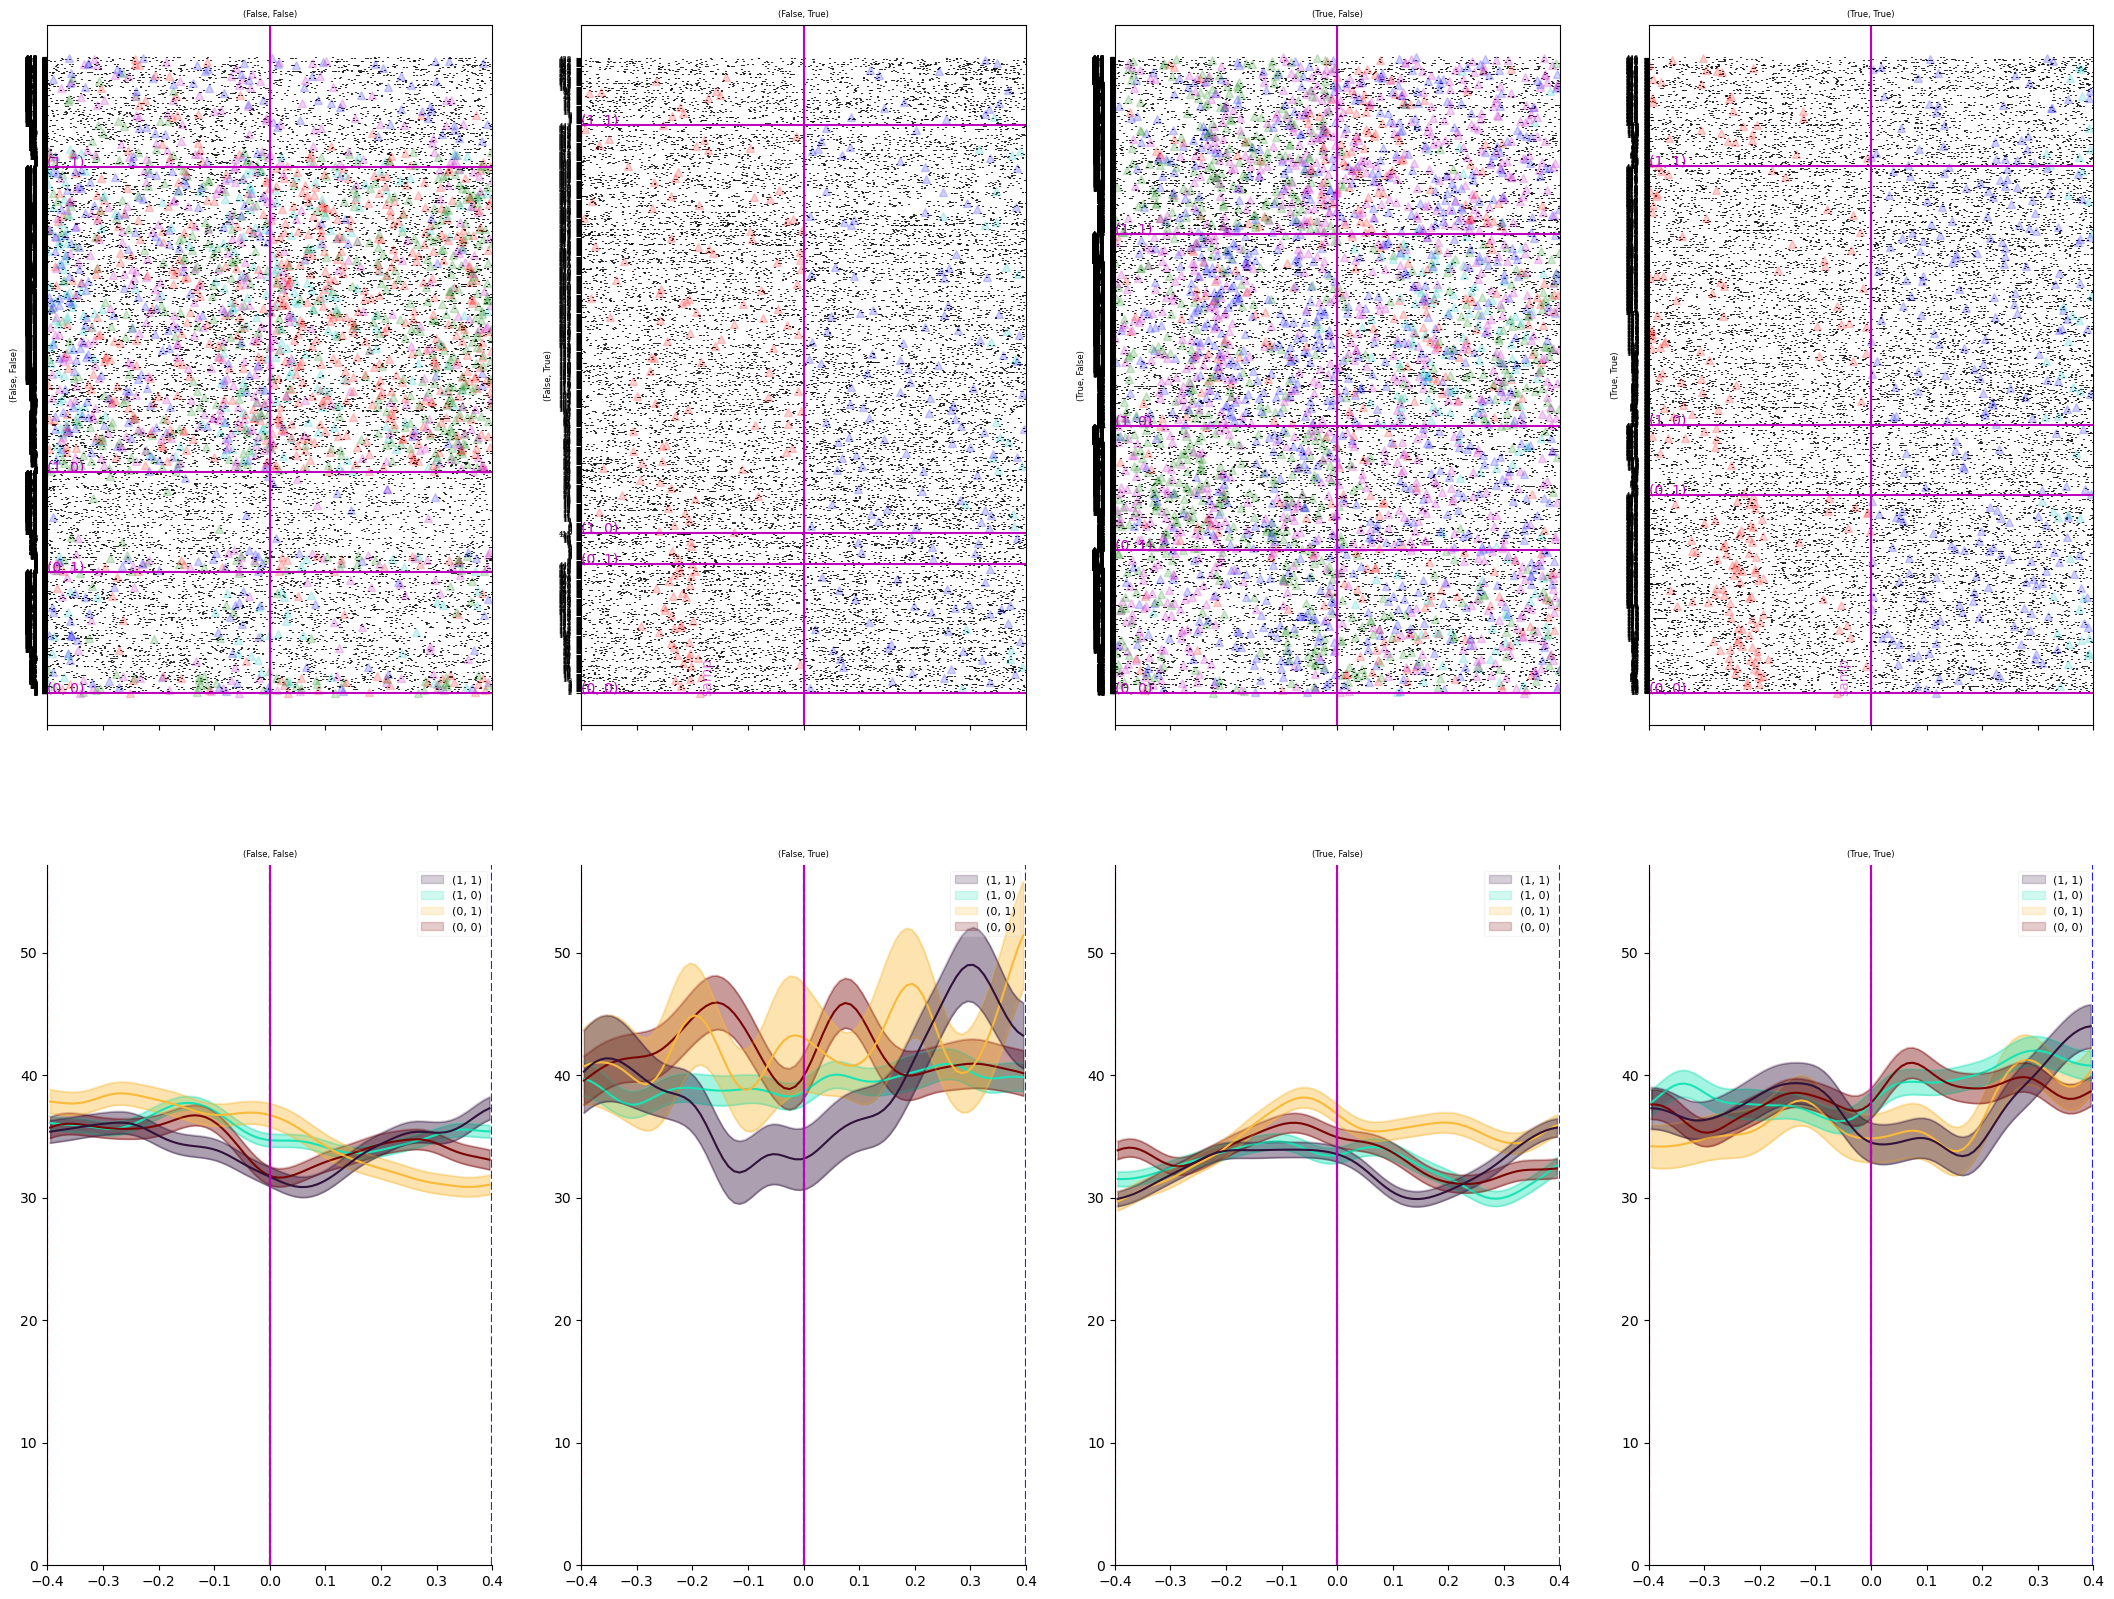

In [34]:
site = SP.Sites[20]

#SP.plotgood_rasters_smfr_each_level_combined(site, "shape-fixation", ['first-fixation-on-shape', 'between_stim-onset_and_go'])
SP.plotgood_rasters_smfr_each_level_combined(site, "loc-fixation", ['first-fixation-on-loc', 'between_stim-onset_and_go'])

In [80]:
# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm_SHAPE"
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

In [ ]:
from pythonlib.tools.plottools import savefig

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "shape-fixation", ['first-fixation-on-shape', 'between_stim-onset_and_go'])
    #fig, axes = SP.plotgood_rasters_smfr_combined(site)
    savefig(fig, fname)
    plt.close("all")

In [37]:
# make new dir for plots
sdir_rasters = "rasters_all_sites_with_sm_LOC"
os.chdir("/home/kgg/Desktop/eyetracking_analyses/")
os.chdir(dirn)
os.mkdir(sdir_rasters)
os.chdir(sdir_rasters)

In [ ]:
from pythonlib.tools.plottools import savefig

for site in SP.Sites:
    fname = f"{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "loc-fixation", ['first-fixation-on-loc', 'between_stim-onset_and_go'])
    #fig, axes = SP.plotgood_rasters_smfr_combined(site)
    savefig(fig, fname)
    plt.close("all")

### Modulation of activity by some variable of interest

In [ ]:
# copying from 230627_v2

# First, append the variables that you wish to analyze
#SP.datasetbeh_append_column("epoch", sn.Datasetbeh) # assign epoch to SP
SP.DfScalar["dummy_var"] = "dummy"

if DEBUG:
    # if you debug, then you have small n trials, so lower the threshold for keeping data.
    print(SP.ParamsGlobals)
    SP.globals_update(globals_nmin=2)
    
# Run this to compute modulation
DF_VAR, DF_FR, DF_FR_LEVELS, list_eventwindow_event = SP.modulationgood_compute_wrapper("shape-fixation", 
                                                                                        DEBUG_CONJUNCTIONS=False, 
                                                                                        THINGS_TO_EXTRACT=["anova"])

In [ ]:
# Plot results and save
sdir_base = "/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking/Diego-230626-0-fixation-middle/modulation_plots"
SP.modulationgood_plot_WRAPPER(DF_VAR, DF_FR, DF_FR_LEVELS, list_eventwindow_event, 
                               var="shape-fixation", vars_conjuction=["dummy_var"],
                               sdir_base=sdir_base, N_WAYS=1)

In [ ]:
# probably breaks - assumes certian things
SP.modulationgood_compute_plot_ALL("shape-fixation", ["event"], PRE_DUR_CALC=-0.4, POST_DUR_CALC=0.4, score_ver="r2_maxtime_1way_mshuff")

In [ ]:
# Run this. You need to first reextract SP, but NOT in DEBUG mode. Or else there is not enough
# data to compute modulation.`a

# Run this to compute modulation
DF_VAR, DF_FR, DF_FR_LEVELS, list_eventwindow_event = SP.modulationgood_compute_wrapper("shape_fixation", 
                                                                                       DEBUG_CONJUNCTIONS=False, 
                                                                                       THINGS_TO_EXTRACT=["anova"])


### Modulation by time (relative to aligned events)

For each site x event, compute a scalar value indiicating how much its actiivyt is modulated
with respect to this event. This moudlation can be increase in fr, decrease, or any
activity pattern that is consistent across trials.

In [ ]:
# Extract modulation, for each site x event

from neuralmonkey.analyses.event_temporal_modulation_v2 import preprocess_and_extract
from neuralmonkey.analyses.event_temporal_modulation import plot_overview

df_modtime = preprocess_and_extract(SP)

In [ ]:
df_modtime

In [ ]:
df_modtime["r2_time_minusmean"].hist

In [ ]:
# Plot overview of modulation

from neuralmonkey.analyses.event_temporal_modulation_v2 import plot_overview

## CHANGE TO BASE DIR ##
os.chdir("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking")
os.chdir(dirn)

# make new dir for plots
SAVEDIR = "modulation_plots"
os.mkdir(SAVEDIR)
os.chdir(SAVEDIR)
##################### PLOTS
plot_overview(df_modtime, SP, SAVEDIR)

### Sanity check - reextract eye tracking, and compare to the clusterfix-extracted timestaps for saccon

In [ ]:
import random
trial = random.choice(sn.get_trials_list(True))
# trial = sn.get_trials_list(True)[0]
print(trial)

In [ ]:
times_clfix = sn.events_get_saccade_clusterfix_results(trial)
times_tdt, vals_tdt_calibrated = sn.beh_extract_eye_good(trial)

%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(times_tdt, vals_tdt_calibrated[:,0], label="x")
ax.plot(times_tdt, vals_tdt_calibrated[:,1], label="y")
sn.plotmod_overlay_trial_events(ax, trial)
for t in times_clfix:
    ax.axvline(t, color="r")
